Preprocessing the text

loading the dataset

In [ ]:
text = 'text_corpus.txt'
with open(text,'r')  as f:
  corpus = f.read()

In [ ]:
corpus

'Deep learning is amazing. Machine learning is powerful. AI is the future.\nComputers can learn from data. Data is crucial for AI.'

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from nltk.tokenize import sent_tokenize,word_tokenize

tokenzization

In [ ]:
tokenized_word_corps = word_tokenize(corpus)
tokenized_word_corps

['Deep',
 'learning',
 'is',
 'amazing',
 '.',
 'Machine',
 'learning',
 'is',
 'powerful',
 '.',
 'AI',
 'is',
 'the',
 'future',
 '.',
 'Computers',
 'can',
 'learn',
 'from',
 'data',
 '.',
 'Data',
 'is',
 'crucial',
 'for',
 'AI',
 '.']

Removing Punctuatuion

In [ ]:
import string
remove_punct_word = [word for word in tokenized_word_corps if word not in string.punctuation]
remove_punct_word

['Deep',
 'learning',
 'is',
 'amazing',
 'Machine',
 'learning',
 'is',
 'powerful',
 'AI',
 'is',
 'the',
 'future',
 'Computers',
 'can',
 'learn',
 'from',
 'data',
 'Data',
 'is',
 'crucial',
 'for',
 'AI']

word2idx and idx2word

In [ ]:
vocab = sorted(set(remove_punct_word))
word2idx = {word: idx for idx,word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}
print("word2idx",list(word2idx.items())[:5])
print("idx2word",list(idx2word.items())[:5])

word2idx [('AI', 0), ('Computers', 1), ('Data', 2), ('Deep', 3), ('Machine', 4)]
idx2word [(0, 'AI'), (1, 'Computers'), (2, 'Data'), (3, 'Deep'), (4, 'Machine')]


Implementing the skipgram model

In [ ]:
def skipgram_pairs(tokens, window_size=2):
    pairs = []
    for i, target_word in enumerate(tokens):
        start = max(i - window_size, 0)
        end = min(i + window_size + 1, len(tokens))

        for j in range(start, end):
            if j != i:
                context_word = tokens[j]
                pairs.append((target_word, context_word))

    return pairs

skipgram_pairs = skipgram_pairs(remove_punct_word, window_size=2)

for i in range(11):
    print(skipgram_pairs[i])

('Deep', 'learning')
('Deep', 'is')
('learning', 'Deep')
('learning', 'is')
('learning', 'amazing')
('is', 'Deep')
('is', 'learning')
('is', 'amazing')
('is', 'Machine')
('amazing', 'learning')
('amazing', 'is')


defining the SkipGramModel

In [ ]:
import torch.nn as nn

class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.output = nn.Linear(embedding_dim, vocab_size)

    def forward(self, input_word):
        # input_word: [batch_size] of word indices
        embeds = self.embedding(input_word)            # Shape: [batch_size, embedding_dim]
        out = self.output(embeds)                      # Shape: [batch_size, vocab_size]
        return out


Loss function and Optimizer

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim

training_data = [(word2idx[target], word2idx[context]) for target, context in skipgram_pairs]

vocab_size = len(word2idx)
embedding_dim = 10  # you can try 20 or 50 later

model = SkipGramModel(vocab_size, embedding_dim)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


Training the model

In [ ]:
# Step 5: Training loop
epochs = 100
for epoch in range(epochs):
    total_loss = 0
    for target_idx, context_idx in training_data:
        # Prepare input and target tensors
        input_tensor = torch.tensor([target_idx], dtype=torch.long)
        target_tensor = torch.tensor([context_idx], dtype=torch.long)

        # Forward pass
        output = model(input_tensor)

        # Compute loss
        loss = loss_function(output, target_tensor)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

Epoch 10/100, Loss: 151.3360
Epoch 20/100, Loss: 140.0955
Epoch 30/100, Loss: 137.1621
Epoch 40/100, Loss: 136.0512
Epoch 50/100, Loss: 135.4508
Epoch 60/100, Loss: 135.0665
Epoch 70/100, Loss: 134.7945
Epoch 80/100, Loss: 134.5881
Epoch 90/100, Loss: 134.4233
Epoch 100/100, Loss: 134.2867


Saving the word embeddings

In [ ]:
# Extract trained word embeddings from the model
word_embeddings = model.embedding.weight.data

# Save the embeddings in a dictionary
embeddings_dict = {idx2word[i]: word_embeddings[i].detach().numpy() for i in range(vocab_size)}
embeddings_dict

{'AI': array([-2.0582697 ,  0.04009096, -1.7592695 , -0.60449195, -0.21890235,
        -0.69570863,  0.46549064,  0.38383332, -0.93763477,  0.9170905 ],
       dtype=float32),
 'Computers': array([-0.12851344, -1.5736694 ,  0.23391418, -0.6954665 , -1.6437857 ,
        -0.324345  , -1.3024942 ,  2.068324  ,  2.7755003 ,  1.8790421 ],
       dtype=float32),
 'Data': array([-2.8294284 , -0.57790655,  0.82429487,  0.74259716, -1.3554401 ,
        -1.2449127 ,  2.0928924 ,  0.67086095,  0.29245052, -1.7674217 ],
       dtype=float32),
 'Deep': array([-0.5829711 ,  3.4161377 , -0.6911324 ,  1.5483065 ,  0.21919227,
        -1.0880533 ,  0.4570321 , -2.406954  ,  0.64441735, -0.62070346],
       dtype=float32),
 'Machine': array([-0.93654615,  0.64801234, -1.1756127 ,  2.6042242 , -1.4157163 ,
        -0.12066769, -2.450898  , -1.6581362 , -0.8295506 , -0.14842953],
       dtype=float32),
 'amazing': array([-0.9853313 , -0.7541986 ,  0.03846208,  0.7417998 ,  0.02964155,
        -1.8700826 ,

Visualizing the word embeddings

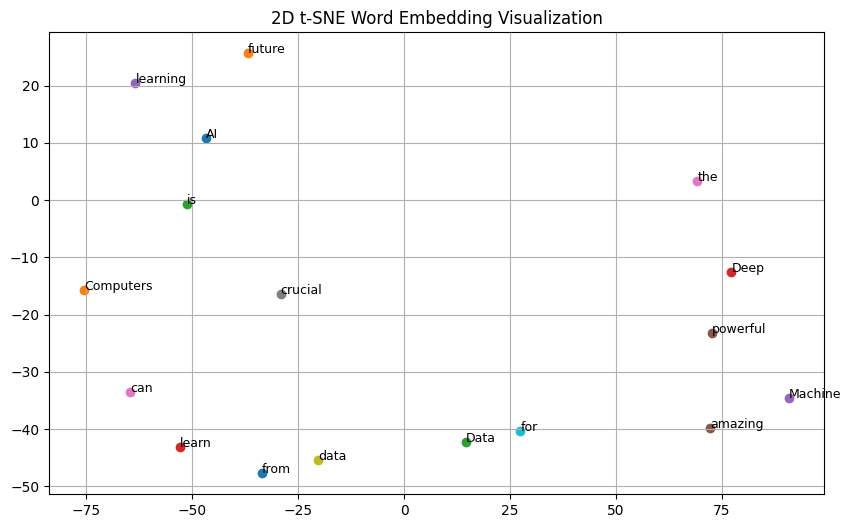

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

words = list(embeddings_dict.keys())
vectors = np.array(list(embeddings_dict.values()))

tsne = TSNE(n_components=2, random_state=42, perplexity=3)
vectors_2d = tsne.fit_transform(vectors)

plt.figure(figsize=(10, 6))
for i, word in enumerate(words):
    x, y = vectors_2d[i]
    plt.scatter(x, y)
    plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.title("2D t-SNE Word Embedding Visualization")
plt.grid(True)
plt.show()

Modification with CBOW

In [ ]:
def generate_cbow_pairs(tokens, window_size=2):
    pairs = []
    for i in range(window_size, len(tokens) - window_size):
        context = tokens[i - window_size:i] + tokens[i + 1:i + window_size + 1]
        target = tokens[i]
        pairs.append((context, target))
    return pairs

# Generate CBOW training data
cbow_pairs = generate_cbow_pairs(remove_punct_word)


Defining the CBOWModel

In [ ]:
class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOWModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, context_idxs):
        embeds = self.embedding(context_idxs)  # shape: [context_len, embed_dim]
        combined = embeds.mean(dim=0).view(1, -1)  # average context vectors
        out = self.linear(combined)                # shape: [1, vocab_size]
        return out

cbow_model = CBOWModel(vocab_size, embedding_dim)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(cbow_model.parameters(), lr=0.01)

Training the CBOW model

In [ ]:
for epoch in range(100):
    total_loss = 0
    for context_words, target_word in cbow_pairs:
        context_idxs = torch.tensor([word2idx[word] for word in context_words], dtype=torch.long)
        target_idx = torch.tensor([word2idx[target_word]], dtype=torch.long)

        output = cbow_model(context_idxs)
        loss = loss_fn(output, target_idx)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 10, Loss: 22.9264
Epoch 20, Loss: 7.2719
Epoch 30, Loss: 2.6673
Epoch 40, Loss: 1.2520
Epoch 50, Loss: 0.7065
Epoch 60, Loss: 0.4504
Epoch 70, Loss: 0.3108
Epoch 80, Loss: 0.2265
Epoch 90, Loss: 0.1716
Epoch 100, Loss: 0.1338


Model evaluation on small analogy

In [ ]:
def find_analogy(word_a, word_b, word_c, embeddings_dict):
    try:
        vec = embeddings_dict[word_b] - embeddings_dict[word_a] + embeddings_dict[word_c]
        # Find closest word
        closest_word = None
        min_dist = float('inf')
        for word, emb in embeddings_dict.items():
            dist = np.linalg.norm(vec - emb)
            if dist < min_dist and word not in [word_a, word_b, word_c]:
                min_dist = dist
                closest_word = word
        return closest_word
    except KeyError:
        return "Word not found in vocab"

In [ ]:
find_analogy("Machine", "learning", "AI", embeddings_dict)

'future'